In [44]:
#import nibabel as nib
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from segmentation_models import get_preprocessing
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import segmentation_models as sm
# تنظیم فریم‌ورک (مخصوص TensorFlow)
sm.set_framework('tf.keras')
sm.framework()

from segmentation_models import Unet
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

In [43]:
# بارگذاری مدل آموزش‌دیده
model_yn = load_model('C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Model/tumor_detection_model(yes_or_no).h5', compile=False)
model_type = load_model('C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Model/tumor_detection_model(yes_or_no).h5', compile=False)
model_seg = load_model('C:/Users/Shahab/Downloads/Jupyter/Brain-Tumor/Model/tumor_segmentation_model2.h5', compile=False)

In [45]:
# تنظیمات
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [34]:
img_path = 'image_15.png'
mask_path = 'mask_15.png'

In [55]:
def yes_no(img_path):
    img = cv.imread(img_path)
    
    img = cv.resize(img, (150,150))
    img = img / 255.0  # نرمال‌سازی مثل ImageDataGenerator(rescale=1./255)
    img = np.expand_dims(img, axis=0)

    y_pred = (model.predict(img, verbose=0) > 0.5).astype("int32")
    return y_pred[0]

In [56]:
def type(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (150,150))
    img = img / 255.0  # نرمال‌سازی مثل ImageDataGenerator(rescale=1./255)
    img = np.expand_dims(img, axis=0)
    y_pred = np.argmax(model_type.predict(img, verbose=0), axis=1) 
    return y_pred

In [57]:
def seg(img_path, mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = np.stack([img]*3, axis=-1)
    img = preprocess_input(img)
    input_img = np.expand_dims(img, axis=(0))
    # پیش‌بینی ماسک
    pred_mask = model_seg.predict(input_img, verbose=0)
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    return binary_mask

In [58]:
def show(img_path, mask_path, binary_mask):
    # بازگردانی تصویر اصلی برای نمایش
    orig_img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    orig_img = cv2.resize(orig_img, (128, 128))
    
    # پیدا کردن کانتور در ماسک باینری
    contours, _ = cv2.findContours(binary_mask[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # گرفتن بزرگ‌ترین کانتور
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
    
        # کشیدن مستطیل روی تصویر اصلی
        boxed = orig_img.copy()
        cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(boxed, "Tumor", (x, y - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    fig , ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].set_title('Predicted Mask')
    ax[0].imshow(binary_mask[0], cmap='gray')
    
    ax[1].set_title('Detected Tumor')
    ax[1].imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
    
    ax[2].set_title('Primary mask')
    ax[2].imshow(mask, cmap='gray')

In [59]:
def Volume(binary_mask, mask_path):
    # ===== پارامترها =====
    pixel_spacing_mm = 0.5  # مثلاً هر پیکسل برابر نیم میلی‌متر (0.5mm x 0.5mm)
    slice_thickness_mm = 5   # ضخامت اسلایس، مثلا ۵ میلی‌متر
    
    # ===== محاسبه تعداد پیکسل تومور =====
    tumor_pixels = np.sum(binary_mask)
    
    # ===== محاسبه مساحت (mm^2) =====
    pixel_area = pixel_spacing_mm ** 2
    tumor_area_mm2 = tumor_pixels * pixel_area
    
    # ===== محاسبه حجم (mm^3) =====
    tumor_volume_mm3 = tumor_area_mm2 * slice_thickness_mm

    # ===== تبدیل به سانتی‌متر مکعب =====
    tumor_volume_cm3 = tumor_volume_mm3 / 1000
    print(f"Predicted volume: {tumor_volume_cm3:.2f} cm³")

    

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_resized_mask = cv2.resize(mask, (128, 128))
    
    # ===== محاسبه تعداد پیکسل تومور =====
    tumor_pixels_mask = np.sum(img_resized_mask != 0)
    
    # ===== محاسبه مساحت (mm^2) =====
    pixel_area = pixel_spacing_mm ** 2
    tumor_area_mm2_mask = tumor_pixels_mask * pixel_area
    
    # ===== محاسبه حجم (mm^3) =====
    tumor_volume_mm3_mask = tumor_area_mm2_mask * slice_thickness_mm

    # ===== تبدیل به سانتی‌متر مکعب =====
    tumor_volume_cm3_mask = tumor_volume_mm3_mask / 1000
    print(f"Actual volume: {tumor_volume_cm3_mask:.2f} cm³")

A brain tumor was detected.
Type : glioma
Predicted volume: 1.75 cm³
Actual volume: 1.76 cm³


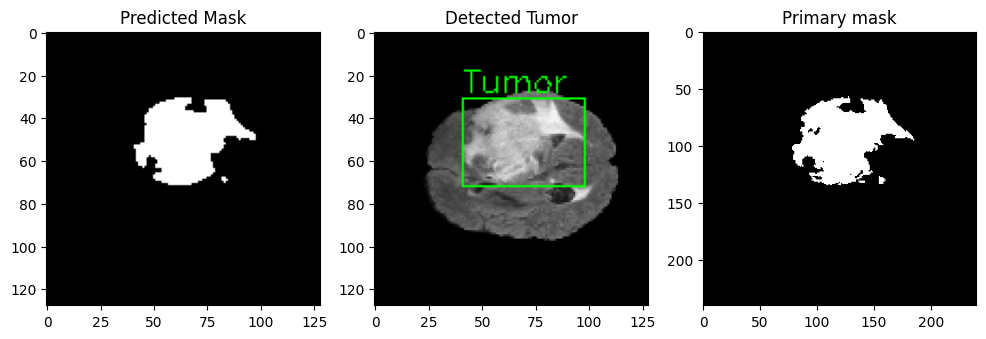

In [60]:
y_pred_yn = yes_no(img_path)
if y_pred_yn == 1:
    print('A brain tumor was detected.')
    y_pred_type = type(img_path)
    if y_pred_type == 0:
        print('Type : glioma')
    elif y_pred_type == 1:
        print('Type : meningioma')
    else:
        print('Type : pituitary')
    binary_mask = seg(img_path, mask_path)
    show(img_path, mask_path, binary_mask)
    Volume(binary_mask, mask_path)
else:
    print('No brain tumor was found.')